In [1]:
# Swap Rate Model: Prediction Interval Estimation of Swap Rate

# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import lightgbm as lgb

In [2]:
# Display Options of DataFrame
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

In [3]:
# Loading Swap Rate Dataset
swap = pd.read_csv("../Data/market-data-swap-rates.csv")

In [4]:
swap

,Date,Start Date,Tenor,Swap Rate
0,2021-01-13,2022-01-13,10y,1.081333
1,2021-01-13,2022-01-13,15y,1.265960
2,2021-01-13,2022-01-13,18M,0.221625
3,2021-01-13,2022-01-13,1y,0.195474
4,2021-01-13,2022-01-13,2y,0.279370
...,...,...,...,...
63175,2024-01-12,2039-01-12,2y,3.424505
63176,2024-01-12,2039-01-12,3y,3.393758
63177,2024-01-12,2039-01-12,4y,3.358897
63178,2024-01-12,2039-01-12,5y,3.319531


In [5]:
# Keep the Forward starting swaps for data input into the swap rate model
swap = swap.drop_duplicates(['Date', 'Tenor'], keep = 'first') # keep the earliest quoted start date of the swap rate
swap

,Date,Start Date,Tenor,Swap Rate
0,2021-01-13,2022-01-13,10y,1.081333
1,2021-01-13,2022-01-13,15y,1.265960
2,2021-01-13,2022-01-13,18M,0.221625
3,2021-01-13,2022-01-13,1y,0.195474
4,2021-01-13,2022-01-13,2y,0.279370
...,...,...,...,...
63103,2024-01-12,2025-01-13,2y,2.982736
63104,2024-01-12,2025-01-13,3y,2.985417
63105,2024-01-12,2025-01-13,4y,3.009677
63106,2024-01-12,2025-01-13,5y,3.038587


In [6]:
## preprocessing

# Convert Tenor to numerical values
swap.loc[swap['Tenor'].str.endswith("M"), 'Tenor'] = "1.5y"
swap['Tenor'] = swap['Tenor'].str.removesuffix('y')
swap['Tenor'] = swap['Tenor'].astype(float)
swap = swap.drop(columns = "Start Date")



C:\Users\chanj\AppData\Local\Temp\ipykernel_23820\145927761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap['Tenor'] = swap['Tenor'].str.removesuffix('y')
C:\Users\chanj\AppData\Local\Temp\ipykernel_23820\145927761.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap['Tenor'] = swap['Tenor'].astype(float)


In [7]:
# Reset index

swap.reset_index(drop = True, inplace=True)

In [8]:
# Define chart: Exploratory Data Analysis
target = 'Swap Rate'
y = swap[target]
x = swap['Date'].index

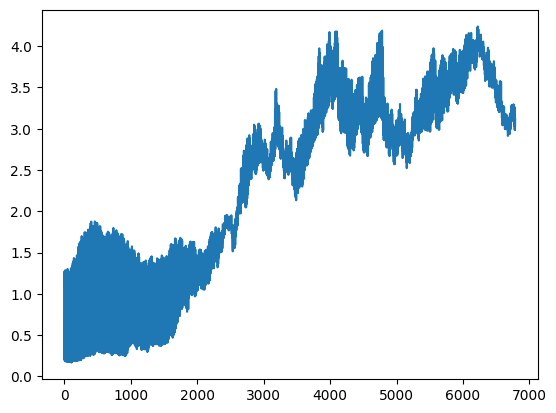

In [9]:
plt.plot(x, y)

In [10]:
y = swap[swap['Tenor'] == 2.0][target].reset_index(drop = True)
y

0      0.279370
1      0.265282
2      0.265514
3      0.258814
4      0.262298
         ...   
749    3.132744
750    3.151444
751    3.154854
752    3.051815
753    2.982736
Name: Swap Rate, Length: 754, dtype: float64

The Autocorrelation plot for the data is:


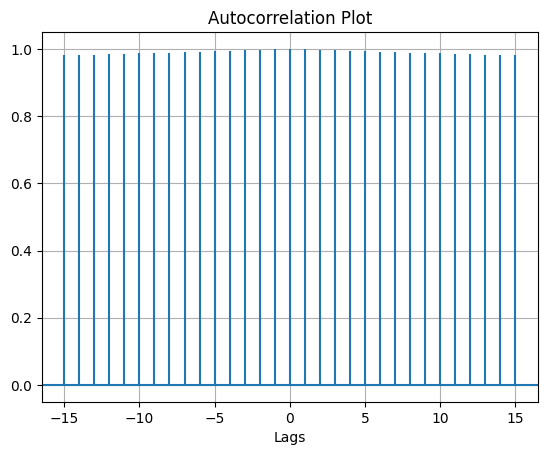

In [11]:
# Time series Exploratory Data Analysis

# ACF plot 

#Adding plot title.
plt.title("Autocorrelation Plot") 
 
#Providing x-axis name.
plt.xlabel("Lags") 
 
#Plotting the Autocorrelation plot.
plt.acorr(y, maxlags = 15) 
 
#Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show() 

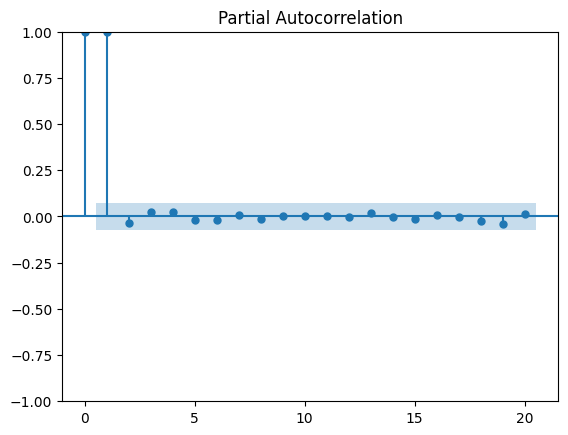

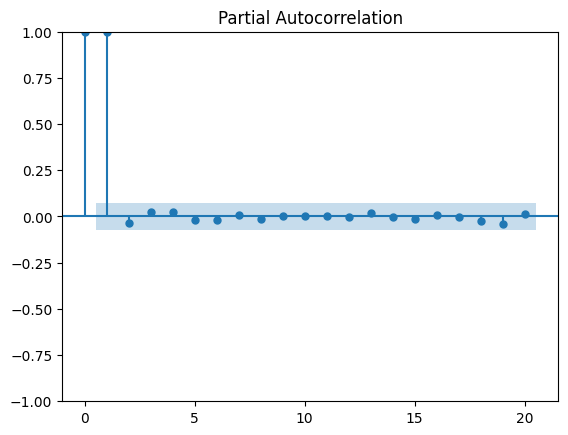

In [12]:
# PACF plot

sm.graphics.tsa.plot_pacf(y, lags=20)
# PACF cutoff at lag 1 -> AR(1) process, use lag 1 as lag variable

In [13]:
# Feature Creation
data = swap
delay = data['Tenor'].nunique()
data['Swap Rate Lag 1'] = data.groupby(['Tenor'])['Swap Rate'].shift(1)
data['Swap Rate Moving Average 2'] = data.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(2).mean().reset_index(0,drop=True)
data['Swap Rate Std 5'] = data.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(5).std().reset_index(0,drop=True)
data.head(100)

,Date,Tenor,Swap Rate,Swap Rate Lag 1,Swap Rate Moving Average 2,Swap Rate Std 5
0,2021-01-13,10.0,1.081333,NaN,NaN,NaN
1,2021-01-13,15.0,1.265960,NaN,NaN,NaN
2,2021-01-13,1.5,0.221625,NaN,NaN,NaN
3,2021-01-13,1.0,0.195474,NaN,NaN,NaN
4,2021-01-13,2.0,0.279370,NaN,NaN,NaN
5,2021-01-13,3.0,0.404284,NaN,NaN,NaN
6,2021-01-13,4.0,0.536341,NaN,NaN,NaN
7,2021-01-13,5.0,0.664396,NaN,NaN,NaN
8,2021-01-13,8.0,0.950975,NaN,NaN,NaN
9,2021-01-15,10.0,1.089143,1.081333,NaN,NaN


In [14]:
# additional feature engineering process, previous low and high (not used in final features)
# Create a new DF containing day low and day high out of all Tenor of swap rate
CurMin = pd.DataFrame(data.groupby(['Date'])['Swap Rate'].min()).rename(columns= {"Swap Rate": "Min Swap Rate (Cur)"})
CurMax = pd.DataFrame(data.groupby(['Date'])['Swap Rate'].max()).rename(columns= {"Swap Rate": "Max Swap Rate (Cur)"})
CurMinMax = pd.merge(CurMin, CurMax, on = ['Date'])

# Merge back to data
data = data.merge(CurMinMax, on = ['Date'], how = 'left')

# Find Lag Variable (Current is not appropriate for prediction: Lookahead bias)
data['Min Swap Rate (Last)'] = data.groupby(['Tenor'])['Min Swap Rate (Cur)'].shift(1)
data['Max Swap Rate (Last)'] = data.groupby(['Tenor'])['Max Swap Rate (Cur)'].shift(1)

In [15]:
# Drop Cur Max Min data after feature engineering finished
data.drop(columns = ["Min Swap Rate (Cur)", "Max Swap Rate (Cur)"], inplace = True)

In [16]:
# Define features and x y to be trained in the model

features = ['Swap Rate Lag 1', 'Swap Rate Moving Average 2', 'Tenor',  'Swap Rate Std 5']
y = data[target]
X = data[features]

In [17]:
# Split the data into train and test sets
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10
seed = 42
# train is now train_ratio% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state = seed, shuffle=False)

# test is now test_ratio% of the initial data set
# validation is now validation_ratio% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = seed, shuffle=False) 


In [18]:
# initialize Gradient Boosting model

# parameters
params = {"n_estimators": 200, 
          "metric": "rmse",        
          "learning_rate": 0.12,           
          "num_leaves": 10,                
          "max_depth": 12,                          
          "early_stopping_round": 4,                         
          "random_state": 42,                         
          "reg_alpha": 0,                          
          "reg_lambda": 1.12,                         
          "min_split_gain": 0.08,                          
          "max_bin": 1000,                         
          "top_rate": 0.2,                        
          "other_rate": 0.1,                         
          "training_metric": True,                       
          "verbose": -1, 
          "force_col_wise": True}
#Train the model with parameters
model = lgb.LGBMRegressor(**params)
model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Calculate R^2 and R^2 adj to evaluate model adequacy: Out of sample performance of GBR
y_pred = model.predict(X_test)
R_sq = sklearn.metrics.r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-R_sq)*(n-1)/(n-p-1)
print("R^2 =", R_sq) 
print("Adjusted R^2 =", adjusted_r2)

R^2 = 0.9522567857377046
Adjusted R^2 = 0.9519734432198275


In [19]:
# Counterpart comparison: Quantile Regression Approach

# Quantile Regression Params
params_quant = {
          "objective": 'quantile',
          "n_estimators": 200,        
          "learning_rate": 0.12,           
          "num_leaves": 10,                
          "max_depth": 12,                          
          "early_stopping_round": 4,                         
          "random_state": 42,                         
          "reg_alpha": 0,                          
          "reg_lambda": 1.12,                         
          "min_split_gain": 0.08,                          
          "max_bin": 1000,                         
          "top_rate": 0.2,                        
          "other_rate": 0.1,                         
          "training_metric": True,                       
          "verbose": 1, 
          "force_col_wise": True
}
# 1 - 2a = confidence
quantile_alpha = 0.25

In [20]:
# Quantile Regression 
# lower bound
lower = lgb.LGBMRegressor(**params_quant, alpha = quantile_alpha)
lower.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
lower_pred = lower.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3010
[LightGBM] [Info] Number of data points in the train set: 5428, number of used features: 4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.211554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 4 rounds
Early stopping, best iteration is:
[110]	training's quantile: 0.0179461	valid_1's quantile: 0.0224612


In [21]:
# Upper bound
upper = lgb.LGBMRegressor(**params_quant, alpha = 1-quantile_alpha)
upper.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
upper_pred = upper.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3010
[LightGBM] [Info] Number of data points in the train set: 5428, number of used features: 4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.902354
Training until validation scores don't improve for 4 rounds
Early stopping, best iteration is:
[39]	training's quantile: 0.0341931	valid_1's quantile: 0.0208651


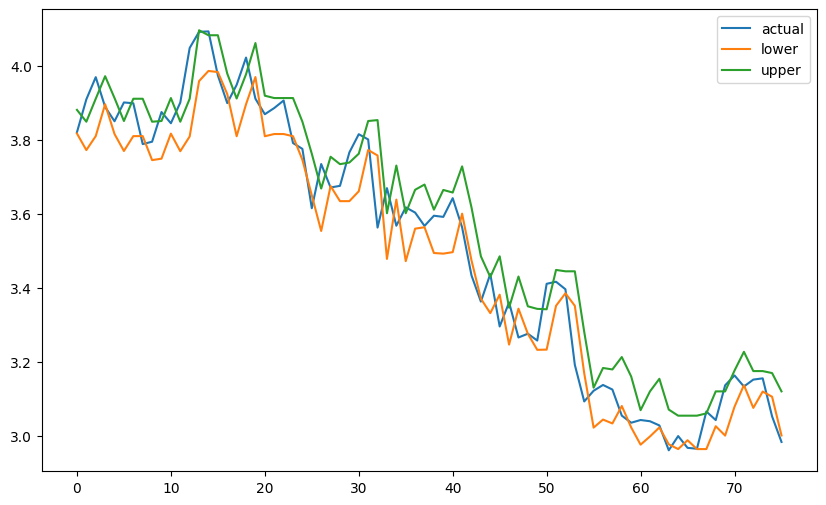

In [22]:
plt.figure(figsize=(10, 6))


y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=0.1, random_state = seed, shuffle=False)
y_pred2y = model.predict(X_2y)
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
#plt.plot(y_pred2y, label='prediction')
plt.plot(lower.predict(X_2y), label='lower')
plt.plot(upper.predict(X_2y), label='upper')
# show the legend
plt.legend()
# show the plot
plt.show()

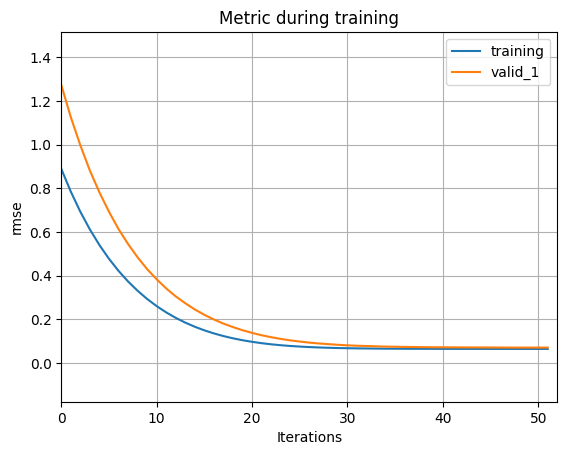

In [23]:
# retrieve performance metrics
lgb.plot_metric(model)
plt.show()

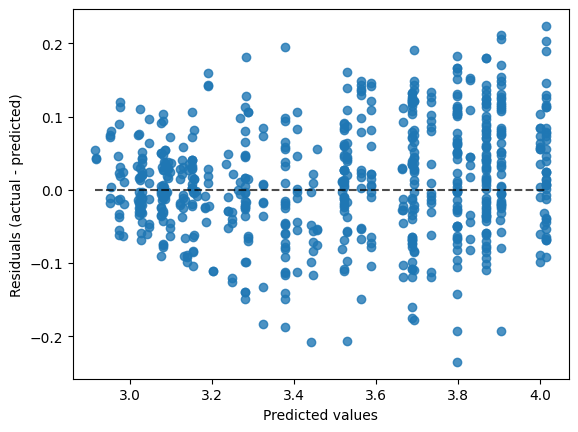

In [24]:
# Residual Plot of GBR model Prediction on Test set

from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

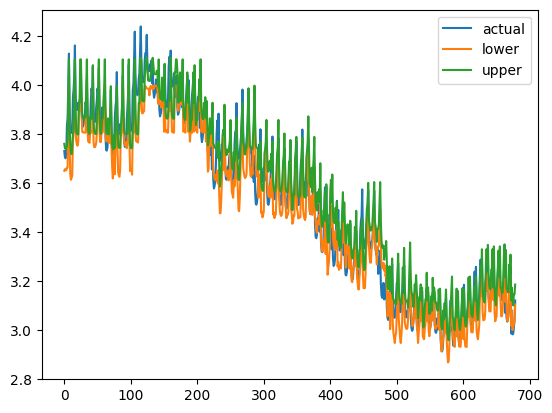

In [25]:
y_test.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_test, label='actual')
#plt.plot(y_pred, label='prediction')
plt.plot(lower_pred, label='lower')
plt.plot(upper_pred, label='upper')
# show the legend
plt.legend()
# show the plot
plt.show()

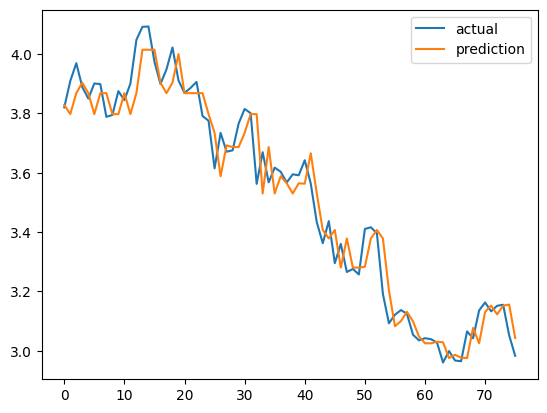

In [26]:
# Compare GBR prediction with actual
y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=0.1, random_state = seed, shuffle=False)
y_pred2y = model.predict(X_2y)
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
plt.plot(y_pred2y, label='prediction')
# show the legend
plt.legend()
# show the plot
plt.show()

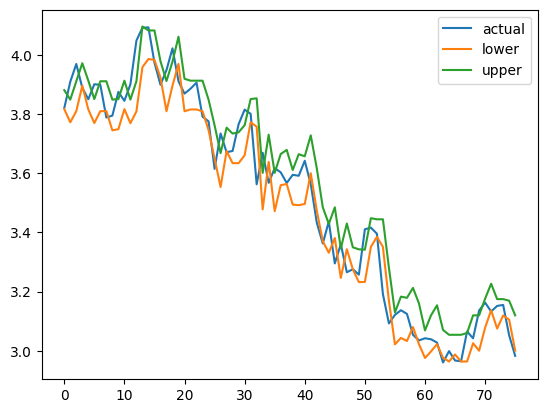

In [27]:
lower_pred = lower.predict(X_2y)
upper_pred = upper.predict(X_2y)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
#plt.plot(y_pred2y, label='prediction')
plt.plot(lower_pred, label='lower')
plt.plot(upper_pred, label='upper')
# show the legend
plt.legend()
# show the plot
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

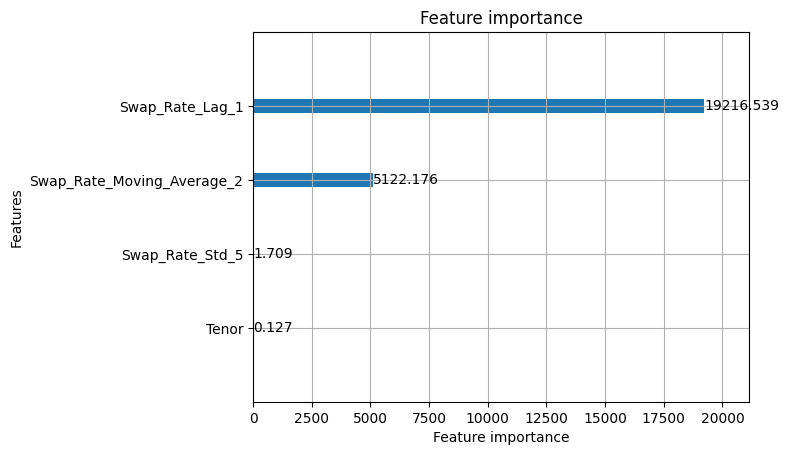

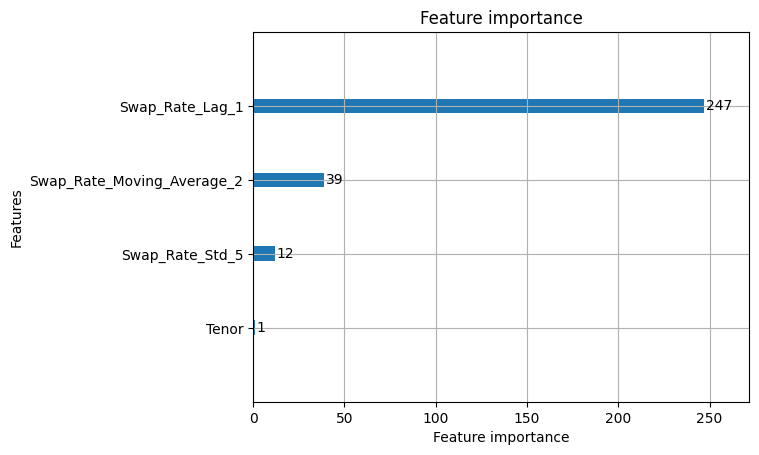

In [28]:
# features importance
lgb.plot_importance(model, importance_type='gain')
lgb.plot_importance(model, importance_type='split')

In [29]:
#### Prediction Interval Implementation: Constant variance, 

#compute the RMSE value: residual
error = sklearn.metrics.mean_squared_error(y_pred, y_test) ** 0.5
error


0.07698044499396672

In [30]:
# Find 
y_upper = y_pred + error
y_lower = y_pred - error

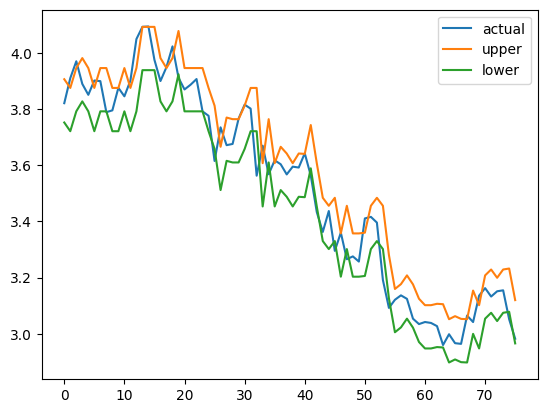

In [31]:
# Prediction Interval of residual implementation

y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=0.1, random_state = seed, shuffle=False)
y_pred2y = model.predict(X_2y)
coef = 1
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
#plt.plot(y_pred2y, label='prediction')
plt.plot(y_pred2y + coef* error, label='upper')
plt.plot(y_pred2y - coef*error, label='lower')
# show the legend
plt.legend()
# show the plot
plt.show()

In [32]:
# Prediction Interval Estimation: Dynamic Residual bound

# compute the prediction error vector on the validation set 
validation_error = abs(model.predict(X_val) - y_val)
model_error = abs(model.predict(X_train) - y_train) 

In [33]:
# Train the error model to calculate dynamic prediction interval
error_model = lgb.LGBMRegressor(**params)
error_model.fit(X_train,model_error, eval_set=[(X_train, model_error), (X_val, validation_error)])
# Calculate R^2 and R^2 adj to evaluate model adequacy
error_pred = error_model.predict(X_test)
R_sq = sklearn.metrics.r2_score(abs(model.predict(X_test) - y_test), error_pred)

In [34]:
# compute the mean and standard deviation of the distribution 
def Error(X_test):
    std_dev = (error_model.predict(X_test).astype("f8"))
    std_dev = np.nan_to_num(std_dev, copy = False, nan = np.nanmin(std_dev)) # imputation
    return std_dev


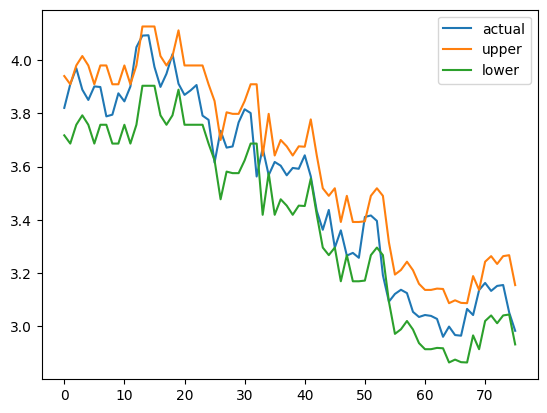

In [35]:
# Plot the error model prediction interval plot
y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=0.1, random_state = seed, shuffle=False)
y_pred2y = model.predict(X_2y)
std = Error(X_2y) * 2
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
#plt.plot(y_pred2y, label='prediction')
plt.plot(y_pred2y + std, label='upper')
plt.plot(y_pred2y - std, label='lower')
# show the legend
plt.legend()
# show the plot
plt.show()
# error prediction model is more sensitive to external change than constant variance model

In [36]:
# Interval Estimation Model Evaluation

In [37]:
# Breach Ratio: Metrics to evaluate interval estimation efficiency
def breachRatio( Lower, Upper, X_test, y_test, alpha, type):
    # alpha-> tail alpha value
    if type == "quantile":
        # Lower: model, Upper: model
        lower_bound = Lower.predict(X_test)
        upper_bound = Upper.predict(X_test)
        
       
    elif type == "normal" or "error model":
        # Lower: bound; Upper: bound
        lower_bound = Lower
        upper_bound = Upper

    inbound = (y_test >= lower_bound) & (y_test <= upper_bound)
    total_obs = y_test.count()
    total_inbound = inbound.sum() # all true value will be summed
    actual_confidence = total_inbound/total_obs 
    exp_confidence = 1 - alpha * 2
    breach_ratio, sign = abs(actual_confidence - exp_confidence), (actual_confidence - exp_confidence) > 0
    return breach_ratio, sign
    
def printBreachRatio(breach_ratio, sign):
    threshold = 0.01
    if breach_ratio < threshold:
        intervalCondition = "Good"
    else:
        intervalCondition = "overbound" if sign else "underbound"
    print("The breach_ratio of Model is:", breach_ratio, "\nThe prediction interval is", intervalCondition)

In [38]:
# Quantile Regression 
a = quantile_alpha
width = np.mean(upper.predict(X_test) - lower.predict(X_test))
breach_ratio, sign = breachRatio(lower, upper, X_test, y_test, a, type = "quantile")
printBreachRatio(breach_ratio, sign)
width

The breach_ratio of Model is: 0.08321060382916051 
The prediction interval is underbound


0.08734866712398841

In [39]:
import scipy.stats as stats
def confidenceIntervalN(confidence):
    # finding coef and alpha for required confidence
    # confidence = 1 - 2a
    a = (1 - confidence)/2
    coef = stats.norm.ppf(1-a)
    return a, coef

In [40]:
## Const Variance Interval Estimation

a, coef = confidenceIntervalN(confidence = 0.9)
width = coef * error * 2
breach_ratio, sign = breachRatio(y_pred - coef * error, y_pred + coef * error, X_test, y_test, a, type = "normal")
printBreachRatio(breach_ratio, sign)
width

The breach_ratio of Model is: 0.0016200294550809957 
The prediction interval is Good


0.2532431283053289

In [41]:
# Error model Interval Estimation

a, coef = confidenceIntervalN(confidence = 0.9)
width = coef * np.mean(Error(X_test)) * 2
breach_ratio, sign = breachRatio(y_pred - coef * Error(X_test), y_pred +  coef * Error(X_test), X_test, y_test, a, type = "error model")
printBreachRatio(breach_ratio, sign)
width

The breach_ratio of Model is: 0.140058910162003 
The prediction interval is underbound


0.18327686273341146

In [42]:
# Conclusion: Select Constant Variance Interval Estimation model, 
# residual plot + breach_ratio (best) supported the claims that the residual is of normal distribution can be used to find CI

In [43]:
# Outputting Model:
from pickle import dump
with open("../model/swapRateModel.pkl", "wb") as f:
    dump(model, f, protocol=5) 